In [60]:
import torch
import math
from torch import nn
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [61]:
img = cv2.imread('./frame_9.png')#[...,::-1]
# Convert the image to HSV color space (Hue, Saturation, Value)
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define the color ranges for green, yellow, and white in HSV
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])

lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

lower_white = np.array([0, 0, 200])
upper_white = np.array([255, 30, 255])

# Create masks for each color
mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
mask_white = cv2.inRange(hsv_image, lower_white, upper_white)

# Set the corresponding color values for each mask
img[mask_green > 0] = [0, 255, 0]       # Green cubes
img[mask_yellow > 0] = [0, 0, 0]      # Yellow floor
img[mask_white > 0] = [0, 0, 255]   # White walls

img = img + (np.random.randn(img.shape[0], img.shape[1], img.shape[2]) * 0.2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


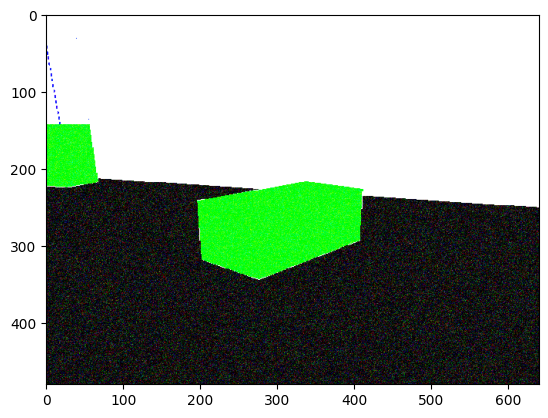

In [62]:
plt.imshow(img)

In [63]:

class CNNwithLSTM(nn.Module):
    def __init__(self, num_classes=4, lstm_hidden_size=256, lstm_num_layers=1):
        super().__init__()
        self.cnn = nn.Sequential(
            # Reduce 1
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Reduce 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Reduce 3
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Reduce 4
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.lstm_input_size = 128 * (640//16) * (480//16)

        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.lstm = nn.LSTM(self.lstm_input_size, lstm_hidden_size, lstm_num_layers, batch_first=True)

        self.fc = nn.Linear(lstm_hidden_size, num_classes)

        # Maybe we can use this fc layer to connect the CNN to the LSTM and reduce the dimensionality of the image.
        # self.fc1 = nn.Linear(64 * (640//8) * (480//8), 128)
        # self.relu4 = nn.ReLU()
        # self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor(), seq: torch.Tensor()): #x is the new image, seq is the previous sequence it gave
        # x, seq = x
        x = self.cnn(x)
        x = x.view(-1, self.lstm_input_size)  # Adjusted to the new input size
        seq = torch.cat([seq[:,1:,:], x.unsqueeze(1)], dim=1)
        x, _ = self.lstm(seq)
        x = x[:, -1, :]
        x = self.fc(x)
        return x, seq

In [64]:
model = CNNwithLSTM()
seq_length = 128
seq = torch.zeros([1,seq_length,model.lstm_input_size])
inp = torch.tensor(np.expand_dims(img.swapaxes(-1, 0).swapaxes(-1, 1), 0), dtype=torch.float32)
optim = torch.optim.Adam(model.parameters())

In [65]:
x = inp
p, seq_new = model(x, seq)
p = p[0]
loss = nn.functional.cross_entropy(p, torch.tensor(1, dtype=torch.long))
loss.backward()
optim.step()
optim.zero_grad()
seq = seq_new.detach()